In [49]:
import pickle
import math

import pandas as pd
import numpy as np
from numpy import percentile

import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle

from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.nonparametric.kde import KDEUnivariate

# Simplifying Counterfactual Fairness
Notebook to replicate results from paper.

Change scenario below to rerun each of the examples. 

The cell after that constructs ground truth models and loads/creates data.

In [50]:
# Choose between "law", "credit" or "healthcare"
scenario = "law"
# Choose to rerun posterior estimation for latent variables (Level 2)
# NOTE: Setting this to True makes notebook slow.
rerun = False

In [51]:
def load_law_data():
    data = pd.read_csv('./data/law_data.csv', index_col=0)
    data = pd.get_dummies(data,columns=['race'],prefix='',prefix_sep='')

    data['male'] = data['sex'].map(lambda z: 1 if z == 2 else 0)
    data['female'] = data['sex'].map(lambda z: 1 if z == 1 else 0)

    data['LSAT'] = data['LSAT'].apply(lambda x: int(np.round(x)))

    data = data.drop(axis=1, columns=['region_first', 'first_pf', 'sander_index'])

    data.loc[((data["male"] == 1) & (data["Black"] == 1)), "Group 1"] = 1
    data.loc[ (data["male"] == 0) & (data["Black"] == 1), "Group 2"] = 1
    data.loc[ (data["male"] == 1) & (data["Black"] == 0), "Group 3"] = 1
    data.loc[ (data["male"] == 0) & (data["Black"] == 0), "Group 4"] = 1

    return train_test_split(data, random_state = 1234, test_size = 0.2) 

def load_credit_data():
    data = pd.read_csv('./data/application_train_small.csv', index_col=0)
    columns_to_include = ['CODE_GENDER',
                          'age',
                          'DAYS_BIRTH',
                          'FLAG_OWN_REALTY',
                          'AMT_INCOME_TOTAL',
                          'NAME_EDUCATION_TYPE',
                          'AMT_CREDIT']
    data['age'] = 0 
    data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
    data['AMT_INCOME_TOTAL'] = abs(data['AMT_INCOME_TOTAL'].astype(int))
    data.loc[abs(data['DAYS_BIRTH']) <= 9125, 'age'] = 0
    data.loc[abs(data['DAYS_BIRTH']) > 9125, 'age'] = 1

    data['CODE_GENDER'] = data['CODE_GENDER'].astype('category')
    data['FLAG_OWN_REALTY'] = data['FLAG_OWN_REALTY'].astype('category')
    data['NAME_EDUCATION_TYPE'] = data['NAME_EDUCATION_TYPE'].astype('category')
    categorical = data.select_dtypes(['category']).columns
    data[categorical] = data[categorical].apply(lambda x: x.cat.codes)
        
    data = data[columns_to_include]

    data.loc[((data["CODE_GENDER"] == 1) & (data["age"] == 1)), "Group 1"] = 1
    data.loc[ (data["CODE_GENDER"] == 0) & (data["age"] == 1), "Group 2"] = 1
    data.loc[ (data["CODE_GENDER"] == 1) & (data["age"] == 0), "Group 3"] = 1
    data.loc[ (data["CODE_GENDER"] == 0) & (data["age"] == 0), "Group 4"] = 1

    return train_test_split(data, random_state = 1234, test_size = 0.2) 

# Data specific values
def build_healthcare_data():
    n = 5000
    df_healthcare = pd.DataFrame({}, columns=['G','R','A','S','C','H'])
    for i in range(n):
        G = pyro.sample('G', dist.Bernoulli(torch.tensor(0.5)))
        R = pyro.sample('R', dist.Bernoulli(torch.tensor(0.7)))
        A = pyro.sample('A', dist.Poisson(torch.tensor(1.0)))
        S = pyro.sample('S', dist.Poisson(G + R + 3*A))
        C = pyro.sample('C', dist.Normal(G + R + A, 1))
        H = pyro.sample('H', dist.Poisson(abs(G + R + 2*A))) # + S + C 
        df_healthcare = df_healthcare.append({
            'G': G.item(),
            'R': R.item(),
            'A': A.item(),
            'S': S.item(),
            'C': C.item(),
            'H': H.item()
        }, ignore_index=True)

    # features = list(df_healthcare.columns)
    # features.remove('H')
    # features.remove('F') # The unseen 'afflicted' variable
    
    df_healthcare.loc[((df_healthcare["G"] == 1) & (df_healthcare["R"] == 1)), "Group 1"] = 1
    df_healthcare.loc[ (df_healthcare["G"] == 0) & (df_healthcare["R"] == 1), "Group 2"] = 1
    df_healthcare.loc[ (df_healthcare["G"] == 1) & (df_healthcare["R"] == 0), "Group 3"] = 1
    df_healthcare.loc[ (df_healthcare["G"] == 0) & (df_healthcare["R"] == 0), "Group 4"] = 1
    
    return train_test_split(df_healthcare, test_size=0.2)

def GroundTruthModelLaw(): # Described here (page 8): https://arxiv.org/pdf/1703.06856.pdf
    exo_dist = {
        'Nr': dist.Bernoulli(torch.tensor(0.75)),
        'Ns': dist.Bernoulli(torch.tensor(0.5)),
        'Nk': dist.Normal(torch.tensor(0.), torch.tensor(1.))
    }
    # sample from bernoulli 0 or 1, 0 at 75% freq (made up)
    R = pyro.sample("R", exo_dist['Nr'])
    S = pyro.sample("S", exo_dist['Ns'])
    
    # random gaussian dist for knowledge. This is the latent variable
    K = pyro.sample("K", exo_dist['Nk'])
    
    # PseudoDelta 
    G = pyro.sample("UGPA", dist.Normal(K + 4.0 * R + 1.5 * S, 0.1))    
    L = pyro.sample("LSAT", dist.Normal(K + 6.0*R + 0.5*S, 0.1)) 
    F = pyro.sample("ZFYA", dist.Normal(K + 3.0*R + 2.0*S, 0.1))

def GroundTruthModelCredit(): 
    exo_dist = {
        'Gender_Bernoulli': dist.Bernoulli(torch.tensor(0.5)),
        # Age ranges from 20 to 70 - centered cauchy at 45, scale is 12.5
        'Age_Cauchy': dist.Cauchy(torch.tensor([45.0 * 365]), torch.tensor([12.5 * 365])),
        # Categorical probabilities here are based on a cursory glance on real distribution...
        'Education_Categorical': dist.Categorical(torch.tensor([0.005,0.2,0.07,0.03,0.695])),
        # Again, cursory glance
        'Real_Estate_Bernoulli': dist.Bernoulli(torch.tensor(0.7)),
        'Responsibility_Normal': dist.Normal(torch.tensor(0.), torch.tensor(1.))
    }
    G = pyro.sample("G", exo_dist['Gender_Bernoulli'])
    A = pyro.sample("A", exo_dist['Age_Cauchy'])
    
    R = pyro.sample("R", exo_dist['Responsibility_Normal'])
    
    # I'm not sure if this is the right treatment for education
    #E = pyro.sample("NAME_EDUCATION_TYPE", dist.Multinomial(probs=torch.tensor([0.005,0.2,0.07,0.03,0.695] * (G + 4*R))))    
    E = pyro.sample("NAME_EDUCATION_TYPE", dist.Normal((G + 4*R), 1))
    I = pyro.sample("AMT_INCOME_TOTAL", dist.Poisson(abs(G + (A/3650) + 2*R))) 
    #S = pyro.sample("FLAG_OWN_REALTY", dist.Bernoulli((A/3650)+R))
    S = pyro.sample("FLAG_OWN_REALTY", dist.Normal((A/3650)+R, 1))

    # Credit!
    C = pyro.sample("AMT_CREDIT", dist.Poisson(S + 5*I + 2*E + 4*R))

def GroundTruthModelHealthcare(): 
    exo_dist = {
        'Gender_Bernoulli': dist.Bernoulli(torch.tensor(0.5)),
        'Race_Bernoulli': dist.Bernoulli(torch.tensor(0.7)),
        'Affliction_Severity': dist.Poisson(torch.tensor(1.0)),
    }
    G = pyro.sample("G", exo_dist['Gender_Bernoulli'])
    R = pyro.sample("R", exo_dist['Race_Bernoulli'])
    A = pyro.sample("A", exo_dist['Affliction_Severity'])
    
    S = pyro.sample("Symptom_Severity", dist.Poisson(G + R + 3*A))
    C = pyro.sample("Clinical_Perspective", dist.Normal(G + R + A, 1))

    # Health care needs!
    H = pyro.sample("Health_Care_Needs", dist.Poisson(abs(G + R + 2*A))) #

if scenario == "healthcare":
    trace_handler = pyro.poutine.trace(GroundTruthModelHealthcare)

    # Healthcare specific values
    latent = 'A'
    train_data, test_data = build_healthcare_data()
    unaware_cols = ['S', 'C']
    full_cols = ['S', 'C', 'G', 'R']
    protect_cols = ['G','R']
    pred = 'H'
    X = ['S', 'C']
    groups = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
    CausalModel = GroundTruthModelHealthcare
elif scenario == "credit":
    trace_handler = pyro.poutine.trace(GroundTruthModelCredit)

    # Credit specific values
    latent = 'R'
    train_data, test_data = load_credit_data()
    unaware_cols = ['FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE']
    full_cols = ['DAYS_BIRTH', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE']
    protect_cols = ['age','CODE_GENDER']
    pred = 'AMT_CREDIT'
    X = ['FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE']
    groups = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
    CausalModel = GroundTruthModelCredit
else:
    trace_handler = pyro.poutine.trace(GroundTruthModelLaw)

    # Law specific values
    latent = 'K'
    train_data, test_data = load_law_data()
    unaware_cols = ['LSAT', 'UGPA']
    full_cols = ['sex', 'Black', 'LSAT', 'UGPA']
    protect_cols = ['Amerindian','Asian','Black','Hispanic','Mexican','Other','Puertorican','White','male','female']
    pred = 'ZFYA'
    X = ['UGPA', 'LSAT']
    groups = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
    CausalModel = GroundTruthModelLaw

## Full Model
Below is the full model i.e. no fairness interventions.

In [52]:
def tensorize(data):
    return torch.tensor(data.values.astype(np.float32))

def train(x_data, y_data, num_iterations=500, verbose=False):
    # Regression model
    num_in = x_data.shape[1]
    x_data = tensorize(x_data)
    y_data = tensorize(y_data)    
    linear_reg_model = PyroModule[nn.Linear](num_in, 1)

    # Define loss and optimize
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)

    for _ in range(num_iterations):
        # run the model forward on the data
        y_pred = linear_reg_model(x_data).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
    
    if verbose:
        # Inspect learned parameters
        print("Learned parameters:")
        for name, param in linear_reg_model.named_parameters():
            print(name, param.data.numpy())
    return lambda data: linear_reg_model(tensorize(data)).detach().numpy()

model_full = train(x_data=train_data[full_cols], y_data=train_data[pred], verbose=True)


Learned parameters:
weight [[-0.03057832 -0.7801994   0.02416475  0.01975931]]
bias [-0.7488089]


## Level 1
Technically Level 1 *only* uses non-descendants of the protected attributes which, I believe, we don't have in this model. Nonetheless, we'll run it with the non-protected attributes for funsies.

In [53]:
model_level1 = train(x_data=train_data[unaware_cols], y_data=train_data[pred])
test_data['Level 1 Predictions'] = model_level1(test_data[unaware_cols])

## Level 2
Below cell will give level 2. Inspired by code from here: https://github.com/Kaaii/CS7290_Fairness_Eval_Project

In [54]:
def inferU(GroundTruthModel, data, X, latent='K'):
        data = data.copy().reset_index()
        # hold all K values
        U=[]
        for i in range(len(data)):
                dictionary = {key:0 for key in X}
                for key in X: dictionary[key] = torch.tensor(data[key][i])
                conditioned = pyro.condition(GroundTruthModel, data=dictionary)
                # use pyro.infer.Importance
                posterior = pyro.infer.Importance(conditioned, num_samples=10).run()
                post_marginal = pyro.infer.EmpiricalMarginal(posterior, latent)
                post_samples = [post_marginal().item() for _ in range(10)]
                # calculate the mean of the inferred
                U += [np.mean(post_samples)]
        return U

In [55]:
if rerun:
    U = inferU(CausalModel, train_data, X, latent=latent)
    import pickle
    U_file = open("./pickles/" + latent + ".pickle", "wb")
    pickle.dump(U, U_file)
    U_file.close()
else:
    U = pickle.load(open("./pickles/" + latent + ".pickle","rb"))

In [56]:
# Data to regress
model_level2 = train(x_data=pd.DataFrame(U), y_data=train_data[pred], verbose=True)

Learned parameters:
weight [[0.02022835]]
bias [0.07194596]


#### Test Performance of U model

In [57]:
if rerun:
    U_test = inferU(GroundTruthModel=CausalModel, data=test_data, X=X, latent=latent)
    U_test_file = open("./pickles/" + latent + '_test.pickle', 'wb')
    pickle.dump(U_test, U_test_file)
    U_test_file.close()
else:
    U_test = pickle.load(open("./pickles/" + latent + '_test.pickle', 'rb'))
test_data['Level 2 Predictions'] = model_level2(pd.DataFrame(U_test))

## Level 3
Below cell will give level 3 results. Inspired by code from here: https://github.com/fiorenza2/CFFair_Emulate/blob/master/CounterFair_Emulate.py  

In [58]:
train_eps, test_eps = [], []
for var_name in X:
    model_eps = train(x_data = train_data[protect_cols], y_data = train_data[var_name])

    train_eps += [train_data[var_name].values.reshape((-1,1)) - model_eps(train_data[protect_cols])]
    test_eps += [test_data[var_name].values.reshape((-1,1)) - model_eps(test_data[protect_cols])]

model_level3 = train(x_data = pd.DataFrame(np.hstack(train_eps)), y_data = train_data[pred])
test_data['Level 3 Predictions'] = model_level3(pd.DataFrame(np.hstack(test_eps)))

## Listing 1
Below is our implementation of Listing 1, which relies on the full model.

In [59]:
test_data["Full Predictions"] = model_full(test_data[full_cols])

def abduct(df, group, full_mean, full_std):
    group_mean = np.mean(df[df[group] == 1]['Full Predictions'])
    group_std = np.std(df[df[group] == 1]['Full Predictions'])
    df.loc[df[group] == 1, "Listing 1"] = (df[df[group] == 1]["Full Predictions"] - group_mean) / group_std
    df.loc[df[group] == 1, "Listing 1"] = (df[df[group] == 1]["Listing 1"] * full_std + full_mean)

for group in groups:
    abduct(test_data, group, full_mean = np.mean(test_data['Full Predictions']), full_std = np.mean(test_data['Full Predictions']))


## Listing 2 
Quantile normalization with Empirical CDF:
Calculate an empirical CDF for each group and for entire dataframe, then for each sample plug ECDF value for its group into overall ECDF.

In [60]:
def cdf_transformation(row, group_map, full_kde):
    # Percentile of rowise value
    p = None

    # Find groupwise ecdf percentile for the row
    for g, ecdf in group_map.items():
        if not math.isnan(row[g]):
            p = ecdf(row['Full Predictions'])

    # Plug into inverse cdf from full kernel density estimate
    return percentile(full_kde.icdf, p * 100, interpolation="nearest")

def quantile_normalization_ecdf(df, groups):
    group_map = {}

    # Calculate empirical cdf for all data - we will map onto this
    full_kde = KDEUnivariate(df['Full Predictions'].to_numpy())
    full_kde.fit()

    # Calculate empirical cdf for each group
    for g in groups:
        group_map[g] = ECDF(df[df[g] == 1]['Full Predictions'].to_numpy())
    
    # For every row, apply the transformation from groupwise ecdf -> full_kde
    df['Listing 2'] = df.apply(lambda row: cdf_transformation(row, group_map, full_kde), axis=1)
    return df

test_data = quantile_normalization_ecdf(test_data, groups)

/var/folders/qj/gh_j11514m37mqtfrlr885k40000gn/T/ipykernel_23405/3615583811.py:11: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return percentile(full_kde.icdf, p * 100, interpolation="nearest")


Full Predictions RMSE: 0.8823511742405925
Level 1 Predictions RMSE: 0.9151234364445066
Level 2 Predictions RMSE: 0.9361979214942423
Level 3 Predictions RMSE: 0.9082313356313896
Listing 1 RMSE: 0.9194051629962778
Listing 2 RMSE: 0.9209864219871956


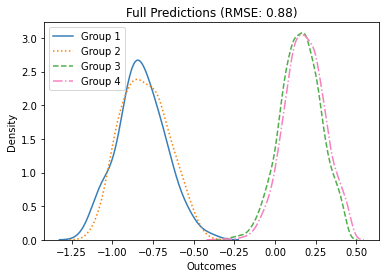

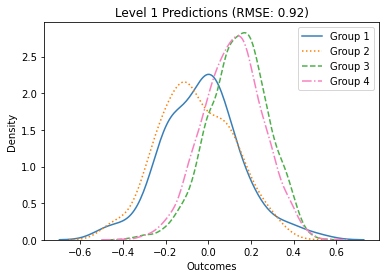

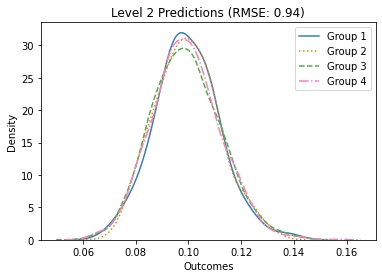

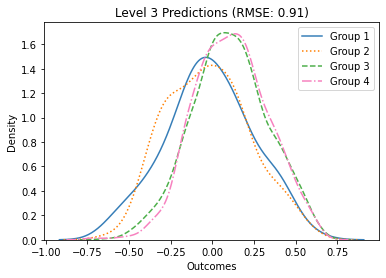

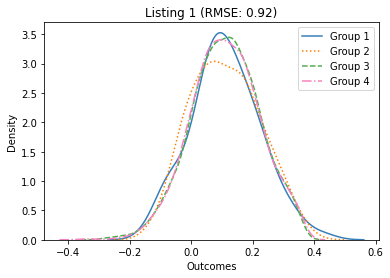

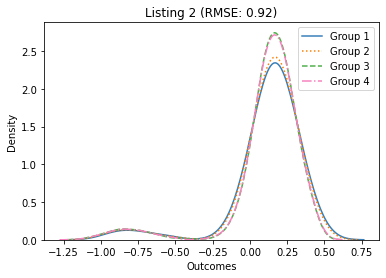

In [61]:
LINESTYLES = ['solid', 'dotted', 'dashed', 'dashdot']
CB_COLORS = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
pred_types = ['Full Predictions', 'Level 1 Predictions', 'Level 2 Predictions', 'Level 3 Predictions', 'Listing 1', 'Listing 2']

for i in range(len(pred_types)):
    mse = mean_squared_error(test_data[pred], test_data[pred_types[i]])
    print(pred_types[i], 'RMSE:', np.sqrt(mse))
    fig, ax = plt.subplots()
    for j in range(len(groups)):
        group = groups[j]
        sns.kdeplot(test_data[test_data[group] == 1][pred_types[i]], ax=ax,label=group, linestyle=LINESTYLES[j], color=CB_COLORS[j])
    plt.title(pred_types[i] + f' (RMSE: {round(np.sqrt(mse), 2)})')
    plt.xlabel('Outcomes')
    plt.legend()
    plt.savefig('plots/'+pred_types[i].replace(' ', '')+'.pdf')

## Demonstrate ordering
Here we demonstrate how the ordering of individuals with respect to target Y is maintainted by Listings 1,2, and not by Levels 1,2,3.

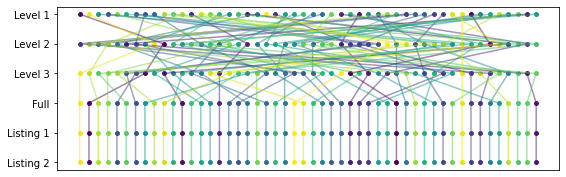

In [62]:
pd.options.mode.chained_assignment = None  # default='warn'

pred_types = ['Level 1 Predictions', 'Level 2 Predictions', 'Level 3 Predictions', 'Full Predictions', 'Listing 1', 'Listing 2']
labels = ['Level 1', 'Level 2', 'Level 3', 'Full', 'Listing 1', 'Listing 2']
rank_labels = [pred_type + ' Rank' for pred_type in pred_types]

num_people = 50
group_label = 'Group 3'
group = test_data[test_data[group_label]==1].sample(n =num_people)
for i in range(len(pred_types)):
    group[rank_labels[i]] = group[pred_types[i]].rank(method='first')

people = group.index.values
cmap = plt.cm.get_cmap('viridis', num_people)

plt.figure(figsize=(9,3))
algs = list(reversed(range(len(labels))))
plt.yticks(algs, labels)
plt.tick_params(bottom=False, labelbottom=False)

for i in range(num_people):
    plt.plot(group.loc[people[i], rank_labels], algs, color=cmap(i), alpha=.5)
    plt.scatter(group.loc[people[i], rank_labels], algs, color=cmap(i), s=15)

plt.savefig('plots/changingranks.pdf')